In [1]:
import os
import sys
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import nltk

In [4]:
from tensorflow.keras.preprocessing import sequence

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, TimeDistributed, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM as LSTM
from tensorflow.keras.layers import GRU as GRU

# Read Data

In [5]:
# f = open("hw4_train.txt", "r")
# #print(f.read()) # reads the whole file at once

In [6]:
# for i, line in enumerate(f):
#     # Start from line 3 (index 2)  # Not necessarily
#     if i >= 2 and i < 15:
#         print (f"{i}: {line}")
#         # print(f.readline())        

In [7]:
# Reading the data takes a long time, so this is a workaround if data has already been read once and saved in a pandas dataframe
# Change to 1 if running for the 1st time, then for subsequent runs, you can choose to change this to 0
REREAD = 0
DATA_FILE = "hw4_reformatted.csv"

In [8]:
if REREAD:
    f = open("hw4_train.txt", "r")
    #print(f.read()) # reads the whole file at once

    data = np.empty((0,2))

    sentence = []
    labels = []
    for i, line in enumerate(f):
        if line != "\n":
            words = line.split()
            word = words[0]
            label = words[3]
            # print (f"{i}: {line} --> Word = {word}: Target = {label}")
            sentence.append(word)
            labels.append(label)
            # print(f.readline())    
        else:
            sentence = " ".join(sentence)
            labels = " ".join(labels)
            data = np.vstack((data,[sentence,labels]))
            sentence = [] # reset sentence
            labels = [] # reset lables

    f.close() 

In [9]:
if REREAD:
    data = pd.DataFrame(data)
    data.columns = ['sentence', 'NER']
    data.info()

In [10]:
if REREAD:
    # Save the data
    data.to_csv(DATA_FILE, index=False)     

In [11]:
if not REREAD:
    try:
        # Read the data already saved
        data = pd.read_csv(DATA_FILE)
        data.info()
    except:
        print("")
        print("-"*150)
        print(f"**** Data file '{DATA_FILE}'' not found. Script will not proceed. Please make sure you have run the script once with REREAD = 1. ****")
        print("-"*150)
        print("")
        sys.exit()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  14987 non-null  object
 1   NER       14987 non-null  object
dtypes: object(2)
memory usage: 234.3+ KB


In [12]:
data.head()

,sentence,NER
0,-DOCSTART-,O
1,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O
2,Peter Blackburn,B-PER I-PER
3,BRUSSELS 1996-08-22,B-LOC O
4,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...


In [13]:
data.tail()

,sentence,NER
14982,on Friday :,O O O
14983,Division two,O O
14984,Plymouth 2 Preston 1,B-ORG O B-ORG O
14985,Division three,O O
14986,Swansea 1 Lincoln 2,B-ORG O B-ORG O


In [14]:
data['len'] = data['sentence'].str.split().str.len()
data.head()

,sentence,NER,len
0,-DOCSTART-,O,1
1,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O,9
2,Peter Blackburn,B-PER I-PER,2
3,BRUSSELS 1996-08-22,B-LOC O,2
4,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...,30


In [15]:
print('Maximum length: {}'.format(data['len'].max()))
print('Minimum length: {}'.format(data['len'].min()))

Maximum length: 113
Minimum length: 1


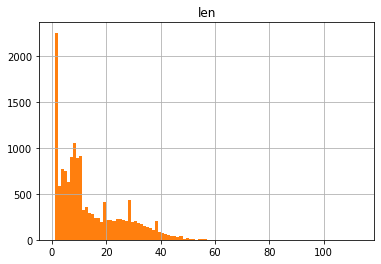

In [16]:
data.hist(bins=100)
data['len'].hist(bins=100)

In [17]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
import numpy as np
time_steps = int(np.quantile(data['len'],0.975))
time_steps

41

# Build Dictionaries

In [18]:
#Text Preprocessing
# Lower string
data['sentence'] = data['sentence'].str.lower()

## Tokenize

Do not tokenize here since that may lead to more tokens than labels in a sentence. 


In [19]:
# import nltk
# from nltk.tokenize import word_tokenize

In [20]:
# df_ = pd.DataFrame(columns=data.columns)

# for index, row in data.iterrows():
#     word_tokens = word_tokenize(row['sentence'])
#     #filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
#     filtered_sentence = [w for w in word_tokens]
#     df_ = df_.append({"NER":  row['NER'], "sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)

# data = df_

In [21]:
# data.head()

In [22]:
# for index, row in data.iterrows():
#     if len(data.iloc[index]['sentence'].split()) != len(data.iloc[index]['NER'].split()):
#         print(f"Index {index} did not match")
#         break

In [23]:
# print(len(data.iloc[66]['sentence'].split()))
# print(len(data.iloc[66]['NER'].split()))

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    data['sentence'].values.astype('U'),
    data['NER'],  # .values.astype('int32'),
    test_size=0.20,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_test)}, y_test: {len(y_test)}")

Number of samples: X_train: 11989, y_train: 11989
Number of samples: X_test: 2998, y_test: 2998


## Vocabulary

In [26]:
corpus = []
for _, row in enumerate(X_train):
  corpus = corpus + row.split(" ")

In [27]:
X_train[:2]

array(['wednesday , august 28th schedule', 'toronto 58 69 .457 15'],
      dtype='<U512')

In [28]:
print(corpus[:15])

['wednesday', ',', 'august', '28th', 'schedule', 'toronto', '58', '69', '.457', '15', '-docstart-', 'two', 'key', 'players', 'left']


In [29]:
# Get only words that have occured more than a certain threshold to remove noise, spelling mistakes and possible tokenization errors (if done).
fdist = nltk.FreqDist(corpus)
print(fdist.most_common()[:20])
vocab = [word for word, count in fdist.most_common() if count >= 1]
print(vocab[:20])

[('the', 6624), ('.', 5848), (',', 5812), ('of', 3062), ('in', 2876), ('to', 2721), ('a', 2529), (')', 2315), ('(', 2314), ('and', 2279), ('"', 1755), ('on', 1654), ('said', 1473), ("'s", 1248), ('for', 1171), ('1', 1125), ('-', 1021), ('at', 921), ('was', 870), ('2', 781)]
['the', '.', ',', 'of', 'in', 'to', 'a', ')', '(', 'and', '"', 'on', 'said', "'s", 'for', '1', '-', 'at', 'was', '2']


In [30]:
len(vocab)

18804

### Encoding and Decoding Dictionary

In [31]:
word_index = {}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
for index, word in enumerate(vocab):
  word_index[word] = index+3

In [32]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
[(i, reverse_word_index.get(i)) for i in np.arange(10)]

[(0, '<PAD>'),
 (1, '<START>'),
 (2, '<UNK>'),
 (3, 'the'),
 (4, '.'),
 (5, ','),
 (6, 'of'),
 (7, 'in'),
 (8, 'to'),
 (9, 'a')]

In [33]:
vocabulary_size = len(word_index.keys())
vocabulary_size

18807

In [34]:
def encode(plain_text: str, word2index: Dict[str, int]) -> List[int]:
  """
  Encodes the plain text as per the word2index doctionary
  :param plain_text: The text to be encoded
  :param word2index: The Encoder dictionary
  """
  return [word2index[token] if token in word2index.keys() else word2index["<UNK>"] for token in plain_text.split(" ")]

def decode(encoded_text, index2word: Dict[int, str]):
  """
  Decodes the encoded text as per the index2word doctionary
  :param encoded_text: The encoded text that is to be decoded
  :param index2word: The decoder dictionary
  """
  return ' '.join([index2word.get(i, '?') for i in encoded_text])

In [35]:
def encode_decode_check(original: str, word2index: Dict[str, int], index2word: Dict[int, str]):
  """
  :param original: The text to be checked for encoding and decoding
  :param word2index: The Encoder dictionary
  :param index2word: The decoder dictionary
  """
  print("\n")
  print(f"Original: {original}")
  encoded = encode(original, word2index)
  print(f"Encoded: {encoded}")
  decoded = decode(encoded, index2word)
  print(f"Decoded: {decoded}")
  same = decoded == original
  print(f"Decoded = Original: {same}")

**Observations:**

Train Reviews and test reviews have UNK tokens introduced for words not in the vocabulary, but apart from this, they match up.

In [36]:
random_train_data = X_train[np.random.choice(len(X_train), 5)]
random_train_data

for data_row in random_train_data:
  encode_decode_check(data_row, word2index=word_index, index2word=reverse_word_index)



Original: second test : headingley - drawn
Encoded: [83, 438, 32, 2824, 19, 448]
Decoded: second test : headingley - drawn
Decoded = Original: True


Original: the spokesman peter lerner said he knew nothing about soldiers having stolen anything from the palestinians .
Encoded: [3, 186, 820, 13606, 15, 27, 2674, 1450, 96, 1102, 966, 13607, 1880, 30, 3, 1605, 4]
Decoded: the spokesman peter lerner said he knew nothing about soldiers having stolen anything from the palestinians .
Decoded = Original: True


Original: -- jakarta newsroom +6221 384-6364
Encoded: [58, 1213, 136, 11941, 11942]
Decoded: -- jakarta newsroom +6221 384-6364
Decoded = Original: True


Original: -docstart-
Encoded: [23]
Decoded: -docstart-
Decoded = Original: True


Original: ventura , calif. 1996-08-28
Encoded: [16254, 5, 4598, 106]
Decoded: ventura , calif. 1996-08-28
Decoded = Original: True


In [37]:
random_test_data = X_test[np.random.choice(len(X_test), 5)]
random_test_data

for data_row in random_test_data:
  encode_decode_check(data_row, word2index=word_index, index2word=reverse_word_index)



Original: " the biggest thing was my fastball , i was able to rotate it pretty good , " foster said . "
Encoded: [13, 3, 1911, 2708, 21, 479, 2, 5, 74, 21, 876, 8, 2, 28, 5474, 451, 5, 13, 11228, 15, 4, 13]
Decoded: " the biggest thing was my <UNK> , i was able to <UNK> it pretty good , " foster said . "
Decoded = Original: False


Original: her reward was the passage in 1993 of the " brady bill " which requires a mandatory five-day waiting period for purchase of handguns and also mandates background checks for would-be gun purchasers .
Encoded: [108, 6735, 21, 3, 8686, 7, 1288, 6, 3, 13, 1211, 595, 13, 61, 14190, 9, 2, 2, 3199, 650, 17, 1902, 6, 2, 12, 85, 2, 8508, 15718, 17, 17175, 2659, 2, 4]
Decoded: her reward was the passage in 1993 of the " brady bill " which requires a <UNK> <UNK> waiting period for purchase of <UNK> and also <UNK> background checks for would-be gun <UNK> .
Decoded = Original: False


Original: 7. jon drummond ( u.s. ) 10.16
Encoded: [404, 4247, 7014, 11, 53,

In [38]:
X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]

In [39]:
print(X_train[:2])
print(X_train_encoded[:2])

['wednesday , august 28th schedule' 'toronto 58 69 .457 15']
[[75, 5, 163, 3243, 944], [481, 900, 227, 3901, 152]]


In [40]:
print(X_test[:2])
print(X_test_encoded[:2])

['press digest - sri lankan newspapers - august 27 .'
 "the spla has fought khartoum 's government forces in the south since 1983 for greater autonomy or independence of the mainly christian and animist region from the moslem , arabised north ."]
[[382, 1218, 19, 419, 2324, 1604, 19, 163, 702, 4], [3, 3021, 36, 2768, 1545, 16, 77, 551, 7, 3, 118, 164, 8273, 17, 4873, 3947, 97, 788, 6, 3, 4746, 1978, 12, 2, 631, 30, 3, 936, 5, 2, 306, 4]]


### Labels

In [41]:
labels = []
for _, row in enumerate(data['NER'].values):
  labels = labels + row.split(" ")

In [42]:
print(labels[:15])

['O', 'B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER', 'I-PER', 'B-LOC', 'O', 'O']


In [43]:
fdist = nltk.FreqDist(labels)
print(fdist.most_common())
label_vocab = [word for word, count in fdist.most_common()]
print(label_vocab)

[('O', 170524), ('B-LOC', 7140), ('B-PER', 6600), ('B-ORG', 6321), ('I-PER', 4528), ('I-ORG', 3704), ('B-MISC', 3438), ('I-LOC', 1157), ('I-MISC', 1155)]
['O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'B-MISC', 'I-LOC', 'I-MISC']


In [44]:
label_vocab_len = len(label_vocab)
label_vocab_len

9

In [45]:
label_index = {}
for index, label in enumerate(label_vocab):
  label_index[label] = index

label_index['<PAD>'] = index+1
label_vocab_len = label_vocab_len + 1

In [46]:
reverse_label_index = dict([(value, key) for (key, value) in label_index.items()])
[(i, reverse_label_index.get(i)) for i in np.arange(label_vocab_len)]

[(0, 'O'),
 (1, 'B-LOC'),
 (2, 'B-PER'),
 (3, 'B-ORG'),
 (4, 'I-PER'),
 (5, 'I-ORG'),
 (6, 'B-MISC'),
 (7, 'I-LOC'),
 (8, 'I-MISC'),
 (9, '<PAD>')]

In [47]:
y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

In [48]:
print(y_train[:2])
print(y_train_encoded[:2])

11112        O O O O O
820      B-ORG O O O O
Name: NER, dtype: object
[[0, 0, 0, 0, 0], [3, 0, 0, 0, 0]]


In [49]:
print(y_test[:2])
print(y_test_encoded[:2])

10005                        O O O B-MISC I-MISC O O O O O
9470     O B-ORG O O B-LOC O O O O O O O O O O O O O O ...
Name: NER, dtype: object
[[0, 0, 0, 6, 8, 0, 0, 0, 0, 0], [0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 1, 7, 0]]


# Check Distribution of labels

In [50]:
#https://www.geeksforgeeks.org/python-count-the-sublists-containing-given-element-in-a-list/
def countList(lst, x): 
    return sum(x in item for item in lst) 

In [51]:
def label_distribution(labels):
    total = 0
    label_count = np.zeros((0, 2))
    for key in reverse_label_index.keys():
        count = countList(labels, key)
        label_count = np.vstack((label_count,[key, count]))
        
    label_count = np.append(label_count, (label_count[:,1]/sum(label_count[:,1]) * 100).reshape(-1,1), axis=1)
    label_count = pd.DataFrame(label_count)
    label_count.columns = ['label', 'count', 'percentage']
    label_count['label'] = label_count['label'].astype(int)
    return label_count

In [52]:
train_label_dist = label_distribution(y_train_encoded)
train_label_dist['dataset'] = 'Train'
# train_label_dist

test_label_dist = label_distribution(y_test_encoded)
test_label_dist['dataset'] = 'Test'
# test_label_dist

label_dist = pd.concat([train_label_dist, test_label_dist])
# label_dist

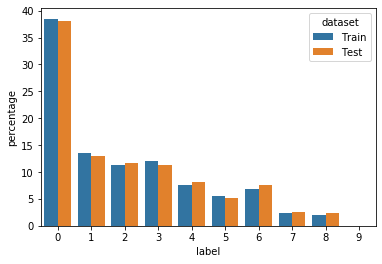

In [53]:
ax = sns.barplot(x="label", y="percentage", hue="dataset", data=label_dist)

**Observations:**

* Roughly the same distribution across the train and test set

# Zero padding

In [54]:
X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)

In [55]:
y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps)
y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps)

In [56]:
print(X_train[0:4])
print(X_train_encoded[0:4])

['wednesday , august 28th schedule' 'toronto 58 69 .457 15' '-docstart-'
 'two key players left a brazilian championship match early on sunday because they had to catch a plane to russia to play with the national team .']
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   75    5  163 3243  944]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  481  900  227 3901  152]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   23]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    52  984  454  338    9 1103  355  134  303   14  112  173   51   3

In [57]:
print(y_train[0:4])
print(y_train_encoded[0:4])

11112                                            O O O O O
820                                          B-ORG O O O O
1643                                                     O
7210     O O O O O B-MISC O O O O O O O O O O O O O B-L...
Name: NER, dtype: object
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0]]


# Models

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(history: tf.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=2)  # Reduced from 10 to lower value since training takes a long time for this model

In [60]:
# import other libs as needed for building model
from tensorflow.keras.callbacks import ModelCheckpoint

# add a checkpoint to save the lowest validation loss
filepath = '.'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [75]:
def create_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, type: str = 'lstm', direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Sequence Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param type Type of sequence model (Options: 'simple_rnn', 'lstm' or 'gru' (Default: 'lstm')
  :type type str
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = Sequential()
  model.add(Embedding(vocabulary_size, embedding_size, input_length=time_steps))
  if type.lower() == 'simple_rnn':
    if direction.lower() == 'uni':
      model.add(RNN(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(RNN(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  elif type.lower() == 'lstm':
    if direction.lower() == 'uni':
      model.add(LSTM(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(LSTM(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  elif type.lower() == 'gru':
    if direction.lower() == 'uni':
      model.add(GRU(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(GRU(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  else:
    sys.exit("You have not passed the right argument for 'type'. Allowed values are 'simple_rnn', 'lstm' or 'gru'.")
  model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_simple_rnn_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Simple RNN Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'simple_rnn', direction, num_neuron, dropout, recurrent_dropout)
  return model

def create_lstm_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a LSTM Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'lstm', direction, num_neuron, dropout, recurrent_dropout)
  return model

def create_gru_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a GRU Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'gru', direction, num_neuron, dropout, recurrent_dropout)
  return model

# LSTM

In [81]:
num_combinations = 3 # Number of hyperparameter combinations

## Unidirectional





---------------------------------------------------------------------------
Training model for hyperparameter combination 1:
Quantile: 0.8749080237694725 --> Time Steps: 30
Embedding Size: 24, Num Neurons: 47, Dropout: 0.3118764001091077, Rec. Dropout: 0.5193700315892974
---------------------------------------------------------------------------


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 24)            451368    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 47)            13536     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 10)            480       
Total params: 465,384
Trainable params: 465,384
Non-trainable params: 0
_________________________________________________________________
None
Train on 11989 samp

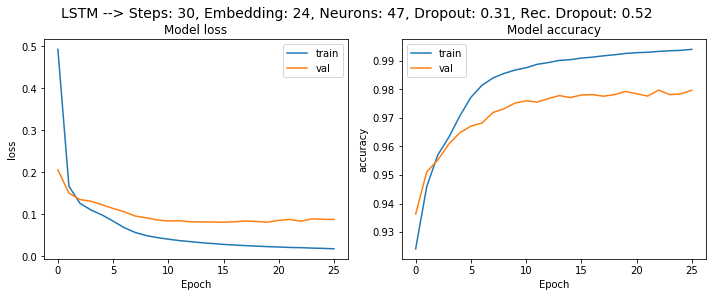

In [77]:
# Random Grid Search 
np.random.seed(42)
tf.random.set_seed(42)

direction = 'uni'

histories = []
models = []
embedding_sizes = []
num_neurons = []
dropouts = []
recurrent_dropouts = []
num_time_steps = []

for hyper_index in np.arange(num_combinations):
 
  # Random Sample Hyperparameter Space
  quantile = np.random.uniform(0.8, 1.00) 
  embeding_size = np.random.randint(10, 100)
  num_neuron = np.random.randint(5, 50)
  dropout = np.random.uniform(0, 0.4)
  recurrent_dropout = np.random.uniform(0.4, 0.6)

  time_steps = int(np.quantile(data['len'], quantile))

  # Encoding of X and y
  X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
  X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]
  y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
  y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

  # Padding of X and y
  X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
  X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)
  y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps)
  y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps)

  print("\n\n\n")
  print("-"*75)
  print(f"Training model for hyperparameter combination {hyper_index+1}:")
  print(f"Quantile: {quantile} --> Time Steps: {time_steps}")
  print(f"Embedding Size: {embeding_size}, Num Neurons: {num_neuron}, Dropout: {dropout}, Rec. Dropout: {recurrent_dropout}")
  print("-"*75)
  print("\n")

  # Build Model and Train
  model = create_lstm_model_multiple_outputs(vocabulary_size=vocabulary_size, embedding_size=embeding_size, num_labels=label_vocab_len, direction = direction, time_steps=time_steps, num_neuron=num_neuron, dropout=dropout, recurrent_dropout=recurrent_dropout)
  print(model.summary())
  history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_test_encoded, y_test_encoded), epochs=50, batch_size=32, callbacks=[es]) #, checkpoint])  # checkpoint causes issues with Bidirectional LSTM
  plot_metrics(history,
               metrics=['loss', 'accuracy'],
               title = f"LSTM --> Steps: {time_steps}, Embedding: {embeding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")

  # Housekeeping
  histories.append(history)
  models.append(model)
  embedding_sizes.append(embeding_size)
  num_neurons.append(num_neuron)
  dropouts.append(dropout)
  recurrent_dropouts.append(recurrent_dropout)
  num_time_steps.append(time_steps)

In [79]:
best_train_accuracies = [max(history.history['accuracy']) for history in histories]
best_test_accuracies = [max(history.history['val_accuracy']) for history in histories]
print(f"Train Accuracies: {best_train_accuracies}")
print(f"Test Accuracies: {best_test_accuracies}")

Train Accuracies: [0.9940362]
Test Accuracies: [0.9797754]


In [80]:
lstm_results_uni = pd.DataFrame({
    'time_steps': num_time_steps,
    'embedding_size':embedding_sizes,
    'num_neuron': num_neurons,
    'dropout': dropouts,
    'recurrent_dropout': recurrent_dropouts,
    'best_train_acc': best_train_accuracies,
    'best_test_acc': best_test_accuracies
  })
lstm_results_uni

,time_steps,embedding_size,num_neuron,dropout,recurrent_dropout,best_train_acc,best_test_acc
0,30,24,47,0.311876,0.51937,0.994036,0.979775


## Bidirectional

In [76]:
# Random Grid Search 
np.random.seed(42)
tf.random.set_seed(42)

direction = 'bi'

histories = []
models = []
embedding_sizes = []
num_neurons = []
dropouts = []
recurrent_dropouts = []
num_time_steps = []

for hyper_index in np.arange(num_combinations):
 
  # Random Sample Hyperparameter Space
  quantile = np.random.uniform(0.8, 1.00) 
  embeding_size = np.random.randint(10, 100)
  num_neuron = np.random.randint(5, 50)
  dropout = np.random.uniform(0, 0.4)
  recurrent_dropout = np.random.uniform(0.4, 0.6)

  time_steps = int(np.quantile(data['len'], quantile))

  # Encoding of X and y
  X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
  X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]
  y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
  y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

  # Padding of X and y
  X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
  X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)
  y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps)
  y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps)

  print("\n\n\n")
  print("-"*75)
  print(f"Training model for hyperparameter combination {hyper_index+1}:")
  print(f"Quantile: {quantile} --> Time Steps: {time_steps}")
  print(f"Embedding Size: {embeding_size}, Num Neurons: {num_neuron}, Dropout: {dropout}, Rec. Dropout: {recurrent_dropout}")
  print("-"*75)
  print("\n")

  # Build Model and Train
  model = create_lstm_model_multiple_outputs(vocabulary_size=vocabulary_size, embedding_size=embeding_size, num_labels=label_vocab_len, direction = direction, time_steps=time_steps, num_neuron=num_neuron, dropout=dropout, recurrent_dropout=recurrent_dropout)
  print(model.summary())
  history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_test_encoded, y_test_encoded), epochs=50, batch_size=32, callbacks=[es]) #, checkpoint])  # checkpoint causes issues with Bidirectional LSTM
  plot_metrics(history,
               metrics=['loss', 'accuracy'],
               title = f"LSTM --> Steps: {time_steps}, Embedding: {embeding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")

  # Housekeeping
  histories.append(history)
  models.append(model)
  embedding_sizes.append(embeding_size)
  num_neurons.append(num_neuron)
  dropouts.append(dropout)
  recurrent_dropouts.append(recurrent_dropout)
  num_time_steps.append(time_steps)





---------------------------------------------------------------------------
Training model for hyperparameter combination 1:
Quantile: 0.8749080237694725 --> Time Steps: 30
Embedding Size: 24, Num Neurons: 47, Dropout: 0.3118764001091077, Rec. Dropout: 0.5193700315892974
---------------------------------------------------------------------------


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 24)            451368    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 94)            27072     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 10)            950       
Total params: 479,390
Trainable params: 479,390
Non-trainable params: 0
_________________________________________________________________
None
Train on 11989 samp

KeyboardInterrupt: 

In [71]:
best_train_accuracies = [max(history.history['accuracy']) for history in histories]
best_test_accuracies = [max(history.history['val_accuracy']) for history in histories]
print(f"Train Accuracies: {best_train_accuracies}")
print(f"Test Accuracies: {best_test_accuracies}")

Train Accuracies: [0.99737537]
Test Accuracies: [0.9825662]


In [72]:
lstm_results_bi = pd.DataFrame({
    'time_steps': num_time_steps,
    'embedding_size':embedding_sizes,
    'num_neuron': num_neurons,
    'dropout': dropouts,
    'recurrent_dropout': recurrent_dropouts,
    'best_train_acc': best_train_accuracies,
    'best_test_acc': best_test_accuracies
  })
lstm_results_bi

,time_steps,embedding_size,num_neuron,dropout,recurrent_dropout,best_train_acc,best_test_acc
0,30,24,47,0.311876,0.51937,0.997375,0.982566
